## Tytułem wstępu

Jeśli dobrze rozumiem, każdy obrazek musi zostać przypisany do 2 klas z n dostępnych, a nie do jednej jak w przypadku multi-class classification. Czyli w wierszach naszego targetu będą dwie jedynki i reszta zer, a nie jedna. 

Postanowiłem zrobić tak, jak umiem, czyli zbudować dataframe z liczbą wierszy równą liczbie wszystkich testowanych obrazów i liczbą kolumn równą ilości wszystkich klas. Ilość tych klas wyznaczona została na podstawie "zagrania" - trzy (papier, kamień, nożyce) i nazwy obrazów - siedem. Każdy obraz to jedno z trzech zagrań i jedno z siedem klas wynikających z nazwy obrazka.

## 0. Wczytanie bibliotek

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
plt.style.use("seaborn")

import seaborn as sns

import cv2

import tensorflow as tf
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss, multilabel_confusion_matrix

from tqdm.notebook import tqdm

pd.set_option("display.max_rows", 3000)

## 1. Przygotowanie targetu

Wszystkich obrazów "paper" jest 840. Są one podzielone na 7 klas, w każdej po 120. Zbudujemy dataframe z informacjami, do którego zagrania należy obraz i do której klasy ze względu na nazwę.

In [2]:
df_paper = pd.DataFrame(columns = ["image_title", "rock", "paper", "scissors", 
                             "class_1", "class_2", "class_3", "class_4", "class_5", "class_6", "class_7"],
                        index = [x for x in range(840)])

# Przypisanie obrazka do klasy "paper"

df_paper.paper = df_paper.paper.fillna(1)

# Przypisanie obrazka do odpowiedniej klasy ze względu na nazwę

threshold = [0, 120, 240, 360, 480, 600, 720]
for i, j in enumerate(threshold):
        df_paper.loc[j:j + 119, "image_title"] = f"paper_{i + 1}"
        df_paper.loc[j:j + 119, f"class_{i + 1}"] = 1

In [3]:
df_paper.sample(10)

,image_title,rock,paper,scissors,class_1,class_2,class_3,class_4,class_5,class_6,class_7
356,paper_3,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
301,paper_3,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
401,paper_4,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
728,paper_7,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
305,paper_3,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
191,paper_2,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
493,paper_5,NaN,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
232,paper_2,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
611,paper_6,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
240,paper_3,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN


Analogicznie robimy z pozostałymi obrazami. Jest ich tyle samo i mają tyle samo klas.

In [4]:
df_rock = pd.DataFrame(columns = ["image_title", "rock", "paper", "scissors", 
                             "class_1", "class_2", "class_3", "class_4", "class_5", "class_6", "class_7"],
                        index = [x for x in range(840)])

# Przypisanie obrazka do klasy "rock"

df_rock.rock = df_rock.rock.fillna(1)

# Przypisanie obrazka do odpowiedniej klasy ze względu na nazwę

threshold = [0, 120, 240, 360, 480, 600, 720]
for i, j in enumerate(threshold):
        df_rock.loc[j:j + 119, "image_title"] = f"rock_{i + 1}"
        df_rock.loc[j:j + 119, f"class_{i + 1}"] = 1

In [5]:
df_rock.sample(10)

,image_title,rock,paper,scissors,class_1,class_2,class_3,class_4,class_5,class_6,class_7
367,rock_4,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
389,rock_4,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
531,rock_5,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
707,rock_6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
603,rock_6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
676,rock_6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
510,rock_5,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
451,rock_4,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
802,rock_7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
837,rock_7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [6]:
df_scissors = pd.DataFrame(columns = ["image_title", "rock", "paper", "scissors", 
                             "class_1", "class_2", "class_3", "class_4", "class_5", "class_6", "class_7"],
                           index = [x for x in range(840)])

# Przypisanie obrazka do klasy "scissors"

df_scissors.scissors = df_scissors.scissors.fillna(1)

# Przypisanie obrazka do odpowiedniej klasy ze względu na nazwę

threshold = [0, 120, 240, 360, 480, 600, 720]
for i, j in enumerate(threshold):
        df_scissors.loc[j:j + 119, "image_title"] = f"scissors_{i + 1}"
        df_scissors.loc[j:j + 119, f"class_{i + 1}"] = 1

In [7]:
df_scissors.sample(10)

,image_title,rock,paper,scissors,class_1,class_2,class_3,class_4,class_5,class_6,class_7
101,scissors_1,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN
27,scissors_1,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN
274,scissors_3,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN
674,scissors_6,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1,NaN
285,scissors_3,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN
384,scissors_4,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN
760,scissors_7,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1
575,scissors_5,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN
590,scissors_5,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN
263,scissors_3,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN


Scalimy tabelę w jedną

In [8]:
# Łaczenie tabel

df = pd.concat([df_paper, df_rock, df_scissors], ignore_index = True)

Puste wartości wypełniami 0 i mamy gotowy target

In [9]:
# Wypełnianie pustych wartości zerami

df = df.fillna(0)

In [10]:
df.sample(10)

,image_title,rock,paper,scissors,class_1,class_2,class_3,class_4,class_5,class_6,class_7
2264,scissors_5,0,0,1,0,0,0,0,1,0,0
2165,scissors_5,0,0,1,0,0,0,0,1,0,0
557,paper_5,0,1,0,0,0,0,0,1,0,0
1569,rock_7,1,0,0,0,0,0,0,0,0,1
145,paper_2,0,1,0,0,1,0,0,0,0,0
867,rock_1,1,0,0,1,0,0,0,0,0,0
1260,rock_4,1,0,0,0,0,0,1,0,0,0
2255,scissors_5,0,0,1,0,0,0,0,1,0,0
1709,scissors_1,0,0,1,1,0,0,0,0,0,0
1229,rock_4,1,0,0,0,0,0,1,0,0,0


## 2. Przygotowanie danych

Przyjrzyjmy się kilku naszym obrazom testowym

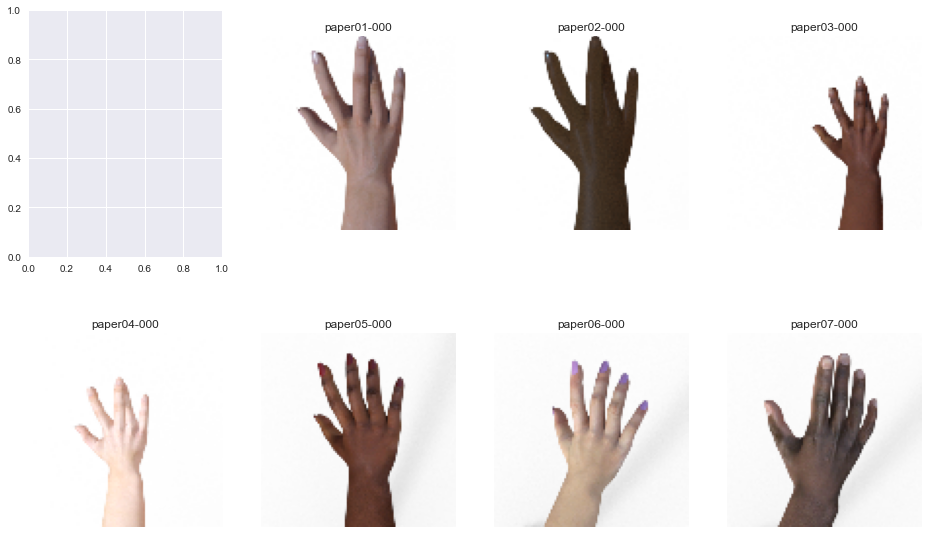

In [11]:
# Rozdzielczość obrazu

image_size = 100

fig, axs = plt.subplots(2, 4, figsize = (16,10))
axs = axs.ravel()     # tworzy jednowymiarową tablicę dla łatwiejszego rysowania w pętli

for i in range(1, 8):
    
    # Wczytanie obrazka
    
    img = cv2.imread(f"rps/rps/paper/paper0{i}-000.png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))

    axs[i].imshow(img)
    axs[i].axis(False)

    axs[i].set_title(f"paper0{i}-000")

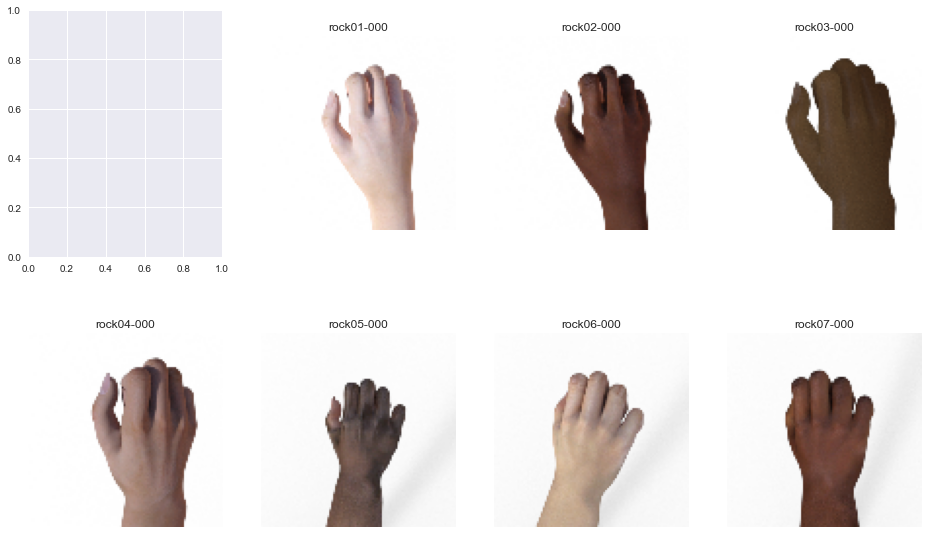

In [12]:
# Rozdzielczość obrazu

image_size = 100

fig, axs = plt.subplots(2, 4, figsize = (16,10))
axs = axs.ravel()     # tworzy jednowymiarową tablicę dla łatwiejszego rysowania w pętli

for i in range(1, 8):
    
    # Wczytanie obrazka
    
    img = cv2.imread(f"rps/rps/rock/rock0{i}-000.png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))

    axs[i].imshow(img)
    axs[i].axis(False)

    axs[i].set_title(f"rock0{i}-000")

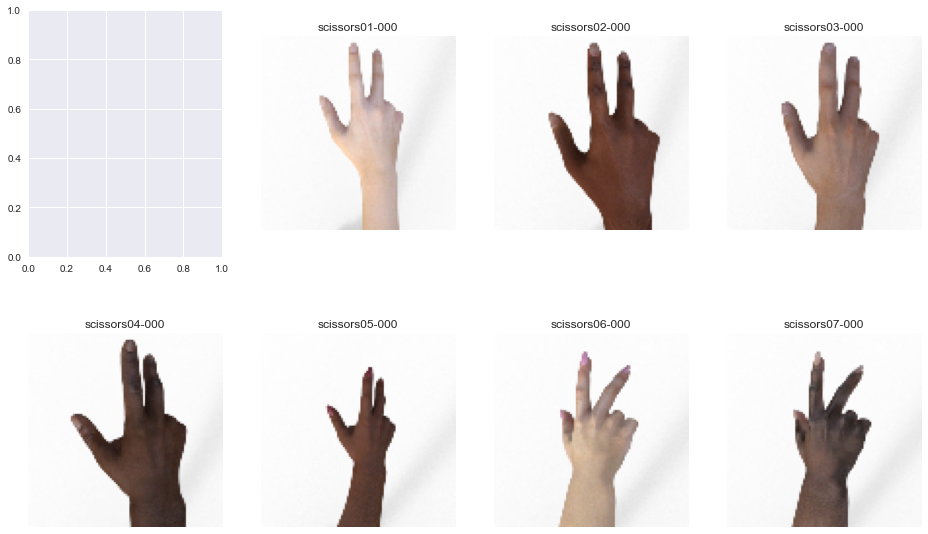

In [13]:
# Rozdzielczość obrazu

image_size = 100

fig, axs = plt.subplots(2, 4, figsize = (16,10))
axs = axs.ravel()     # tworzy jednowymiarową tablicę dla łatwiejszego rysowania w pętli

for i in range(1, 8):
    
    # Wczytanie obrazka
    
    img = cv2.imread(f"rps/rps/scissors/scissors0{i}-000.png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))

    axs[i].imshow(img)
    axs[i].axis(False)

    axs[i].set_title(f"scissors0{i}-000")

Utworzymy tablicę reprezentujące obrazy treningowe. Każdy piksel obrazu będzie odpowiadał konkretnej współrzędnej tablicy, a kolor będzie zapisany jako trzy współrzędne przestrzeni kolorów RGB.

In [14]:
train_images = np.ndarray(shape = (len(df), image_size, image_size, 3), dtype = int)

i = 0
for move in tqdm(["paper", "rock", "scissors"]):
    for num_of_class in tqdm(range(1, 8)):
        for num_of_pic in range(120):
            if num_of_pic < 10:
                img = load_img(f"rps/rps/{move}/{move}0{num_of_class}-00{num_of_pic}.png", target_size = (image_size, image_size))
                train_images[i] = np.uint8(img_to_array(img))
                i += 1
            elif (num_of_pic >= 10) & (num_of_pic < 100):
                img = load_img(f"rps/rps/{move}/{move}0{num_of_class}-0{num_of_pic}.png", target_size = (image_size, image_size))
                train_images[i] = np.uint8(img_to_array(img))
                i += 1
            else:
                img = load_img(f"rps/rps/{move}/{move}0{num_of_class}-{num_of_pic}.png", target_size = (image_size, image_size))
                train_images[i] = np.uint8(img_to_array(img))
                i += 1

print(f"Training set shape:   {train_images.shape}")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training set shape:   (2520, 100, 100, 3)


Pierwsza liczba (2520) to ilość naszych obrazów, druga i trzecia (100) to rozdzielczość obrazka - ilość pikseli w pionie i poziomie, a czwarta (3) to ilość współrzędnych opisująch kolor piksela.

Dokonamy podziału tablicy ze zdjęciami treningowymi (nasze X) oraz tablicy z informacją o wystąpieniu klasy (nasze Y) na dane treningowe i testowe

In [15]:
target = df[["rock", "paper", "scissors", "class_1", "class_2", "class_3", "class_4", "class_5", "class_6", "class_7"]]

x_train, x_test, y_train, y_test = train_test_split(train_images, target.to_numpy(), 
                                                    test_size = 0.1, random_state = 11) 

print(f"x_train shape:   {x_train.shape}")
print(f"y_train shape:   {y_train.shape}")
print(f"x_test shape:   {x_test.shape}")
print(f"y_test shape:   {y_test.shape}")

x_train shape:   (2268, 100, 100, 3)
y_train shape:   (2268, 10)
x_test shape:   (252, 100, 100, 3)
y_test shape:   (252, 10)


Zbiory mamy przygotowane, możemy przystąpić do modelowania

## 4. Model CNN

In [16]:
epochs = 20        # ile razy algorytm ma powtórzyć działanie na całym zbiorze danych 
batch_size = 8     # po ilu każdych próbkach algorytm ma się zaktualizować

# Wczesne zatrzymanie po wykryciu, że model przestał się uczyć (domyślnie - "loss" nie maleje na zbiorze testowym)

early_stop = EarlyStopping(patience = 5,                   # liczba "epoch" bez poprawy, po ilu model ma się zatrzymać
                          restore_best_weights = True,
                          verbose = 1)                      # przywrócenie najlepszych parametrów modelu
                                               
# Zmniejszenie "learning rate" po wykryciu, że model przestał się uczyć (domyślnie - "loss" nie maleje na zbiorze testowym)

red_lr = ReduceLROnPlateau(patience = 3, verbose = 1)      # liczba "epoch" bez poprawy, po ilu model redukuje "learning rate"

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = (image_size, image_size, 3), activation = "relu", padding = "same"))
model.add(BatchNormalization())     
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dropout(0.25))
model.add(Dense(10, activation = "sigmoid"))

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["binary_accuracy"])

cnn_rps = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = epochs, 
                    batch_size = batch_size, callbacks = [early_stop, red_lr], verbose = 1)

Epoch 1/20
284/284 [==============================] - 230s 805ms/step - loss: 0.7970 - binary_accuracy: 0.9349 - val_loss: 0.9631 - val_binary_accuracy: 0.8833
Epoch 2/20
284/284 [==============================] - 235s 827ms/step - loss: 0.1066 - binary_accuracy: 0.9859 - val_loss: 4.0787 - val_binary_accuracy: 0.8119
Epoch 3/20
284/284 [==============================] - 230s 811ms/step - loss: 0.0473 - binary_accuracy: 0.9941 - val_loss: 0.1934 - val_binary_accuracy: 0.9770
Epoch 4/20
284/284 [==============================] - 260s 914ms/step - loss: 0.0286 - binary_accuracy: 0.9957 - val_loss: 0.6875 - val_binary_accuracy: 0.9421
Epoch 5/20
284/284 [==============================] - 225s 793ms/step - loss: 0.0578 - binary_accuracy: 0.9923 - val_loss: 3.4547 - val_binary_accuracy: 0.8643
Epoch 6/20
284/284 [==============================] - 225s 794ms/step - loss: 0.0674 - binary_accuracy: 0.9929 - val_loss: 0.6532 - val_binary_accuracy: 0.9433

Epoch 00006: ReduceLROnPlateau reducing

Zobaczmy, jak wyglądają wykresy "accuracy" i "loss"

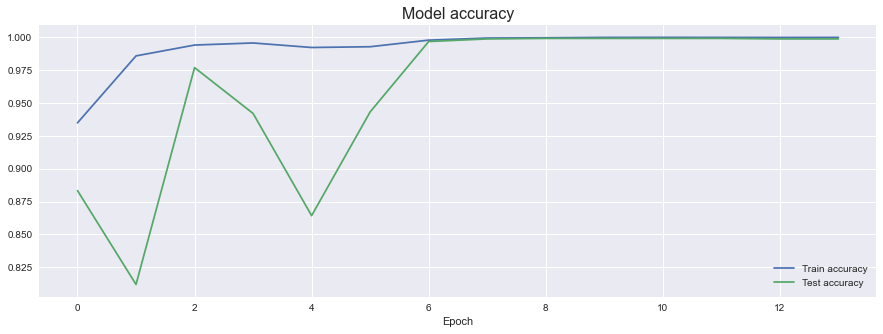

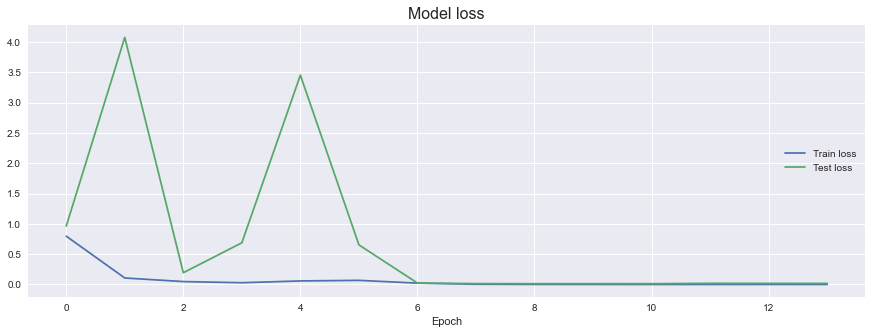

In [17]:
plt.figure(figsize = (15, 5))

plt.plot(cnn_rps.history["binary_accuracy"])
plt.plot(cnn_rps.history["val_binary_accuracy"])

plt.title("Model accuracy", size = 16)
plt.xlabel("Epoch")
plt.legend(["Train accuracy", "Test accuracy"], loc = 4)
plt.show()
           
plt.figure(figsize = (15, 5))

plt.plot(cnn_rps.history["loss"])
plt.plot(cnn_rps.history["val_loss"])

plt.title("Model loss", size = 16)
plt.xlabel("Epoch")
plt.legend(["Train loss", "Test loss"], loc = 7)

plt.show()

Widzimy, że wygląda to aż za dobrze :) "Test accuracy" i "test loss" po początkowych wahaniach i zmniejszeniu learning rate przez ReduceLROnPlateau ustabilizowały się. EarlyStopping po 14 epoce zakończył uczenie algorytmu.

Zobaczmy wyniki podsmumowujące model

In [18]:
y_pred = model.predict(x_test)
loss, acc = model.evaluate(x_test, y_test)
print(f"Average precision score: {label_ranking_average_precision_score(y_test, y_pred)}")
print(f"Ranking loss :           {label_ranking_loss(y_test, y_pred)}")
print(f"loss:                    {loss}")
print(f"acc:                     {acc}")

8/8 [==============================] - 6s 815ms/step - loss: 0.0125 - binary_accuracy: 0.9992
Average precision score: 0.9993386243386244
Ranking loss :           0.000248015873015873
loss:                    0.012462408281862736
acc:                     0.9992063045501709


Bardzo ładnie. :) Tak dobre wyniki powinny martwić, a juz na pewno skłonić do rozważań na temat poprawności modelu. :)

Zobaczmy jak przedstawia się confusion matrix dla każdej klasy. Musimy najpierw zaokrąglić wyniki do wartości binarnych

In [19]:
for i in range(y_pred.shape[0]):
    for j in range(y_pred.shape[1]):
        if y_pred[i][j] > 0.5:
            y_pred[i][j] = 1
        else:
            y_pred[i][j] = 0

In [20]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[164,   0],
        [  0,  88]],

       [[167,   0],
        [  1,  84]],

       [[173,   0],
        [  0,  79]],

       [[216,   0],
        [  0,  36]],

       [[213,   0],
        [  0,  39]],

       [[212,   0],
        [  0,  40]],

       [[215,   1],
        [  0,  36]],

       [[218,   0],
        [  0,  34]],

       [[223,   0],
        [  0,  29]],

       [[214,   0],
        [  0,  38]]], dtype=int64)

Na koniec porównajmy wyniki klasyfikacji niektórych obrazów

In [21]:
for i in tqdm([random.randint(0, x_test.shape[0]) for x in range(10)]):
    print(f"\nRandom train image no {i}")
    print(f"\tPredictors:    {y_pred[i]}")
    print(f"\tTrue labels:   {y_test[i]}")

  0%|          | 0/10 [00:00<?, ?it/s]


Random train image no 100
	Predictors:    [0 0 1 0 0 0 1 0 0 0]
	True labels:   [0 0 1 0 0 0 1 0 0 0]

Random train image no 196
	Predictors:    [0 1 0 1 0 0 0 0 0 0]
	True labels:   [0 1 0 1 0 0 0 0 0 0]

Random train image no 192
	Predictors:    [0 0 1 0 1 0 0 0 0 0]
	True labels:   [0 0 1 0 1 0 0 0 0 0]

Random train image no 148
	Predictors:    [0 0 1 0 0 0 0 0 0 1]
	True labels:   [0 0 1 0 0 0 0 0 0 1]

Random train image no 98
	Predictors:    [0 0 1 0 0 1 0 0 0 0]
	True labels:   [0 0 1 0 0 1 0 0 0 0]

Random train image no 111
	Predictors:    [1 0 0 0 0 1 0 0 0 0]
	True labels:   [1 0 0 0 0 1 0 0 0 0]

Random train image no 58
	Predictors:    [0 0 1 0 0 0 1 0 0 0]
	True labels:   [0 0 1 0 0 0 1 0 0 0]

Random train image no 34
	Predictors:    [1 0 0 0 0 0 0 0 0 1]
	True labels:   [1 0 0 0 0 0 0 0 0 1]

Random train image no 13
	Predictors:    [0 0 1 0 0 0 0 0 1 0]
	True labels:   [0 0 1 0 0 0 0 0 1 0]

Random train image no 84
	Predictors:    [0 0 1 0 1 0 0 0 0 0]
	True labels:

Widzimy z confusion martix i powyższych porównań, że nasz model się nie myli :)

## 5. Podsumowanie

Stworzyliśmy dataframe, który każdemu obrazowi przypisał występowanie dwu z dziesięciu klas. Obraz mógł przyjąć jedną z trzech klas dotyczących zagrania (papier, kamień, nożyce) oraz jedną z siedmiu pozostałych wyznaczonych z nazwy obrazka.
Następnie załadowaliśmy obrazy do tablicy i podzieliliśmy je wraz z odpowiadającymi im informacjami o występowaniu klas na zbiór treningowy i testowy w stosunku 9:1 (tak było w poleceniu). Zbudowaliśmy model, który okazał się być super dobry.
W odróżnieniu od multi-class classification, w ostatniej powłoce trzeba ustawić "sigmoid" jako funkcję aktywacji, bo obraz przyjmuje wiele klas. Ważne też by ustawić "binary_crossentropy" i "binary_accuracy" w kompilerze.

Wnioski:
Tak dobry model każe się zastanowić, czy wszystko jest ok. :) Model bardzo dobrze dopasował się do danych testowych. Żeby się upewnić, że to nie przypadek, należałoby przeprowadzić kroswalidację. Niestety, trwa to zbyt długo, dlatego tego nie zrobiłem. Być może zbiór testowy jest zbyt mały w stosunku do zbioru treningowego, albo model jest zbyt "poteżny" dla takich danych. A może wszystko jest ok? W każdym razie, idealny model to zawsze czerwona lampka w głowie i stawianie pytań. ;)

To mój pierwszy multi-label classification i drugi model CNN, jaki przetrenowałem, także chyba nie jest źle ;)